# 1.) Data preprocessing

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date

In [2]:
#Ceilometer data
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

#CTM model data
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
#WRF model data

data_path = "C:/Users/vichu/Downloads/90106"

wrf_data_path = "//WRF_PBLH"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)



In [4]:
#Converting UTC to AEST

def convert_df_to_datetime_wrf(df):
    df['time_AEST'] = (df['time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,'date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[5:7]
        day_date_1 = int(date_1[8::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    df = df[~df.index.duplicated(keep = 'first')]
    
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H')
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [5]:
wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)

In [6]:
#Combining WRF with CL and CTM model data

import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

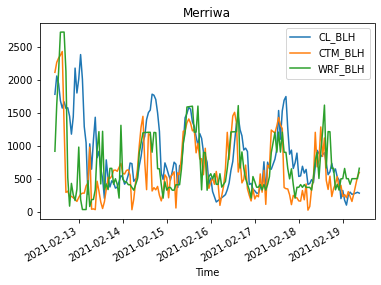

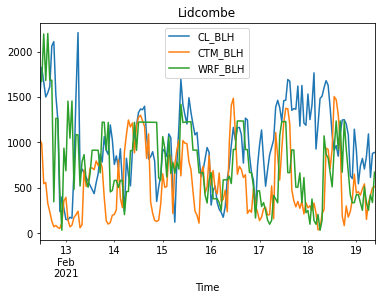

In [7]:
#Plots of Lidcombe and Merriwa BL heights
bl_plot('Merriwa', wrf_df_merriwa)
bl_plot('Lidcombe', wrf_df_lidcombe)

### 1.1 Scraping of air quality data

In [8]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [9]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [10]:

df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]

In [11]:
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-20',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [12]:
#Consolidating all the data in a dict
data = {site: bl_external(site, id) for site, id in sites.items()}

# 2.) Correlation analysis and statistical metrics

### 2.1 Correlation analysis

In [13]:
#Calculating correlation and p-values for the features w.r.t the BL height

def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [14]:
#Correlation and p values for Lidcombe and Merriwa

'''
corr('all', 'pearson').iloc[:, :3]
p_value('all').iloc[:, :3]
corr('Lidcombe', 'pearson').iloc[:, :3]
p_value('Lidcombe').iloc[:, :3]
corr('Merriwa', 'pearson').iloc[:, :3]
p_value('Merriwa').iloc[:, :3]
'''

"\ncorr('all', 'pearson').iloc[:, :3]\np_value('all').iloc[:, :3]\ncorr('Lidcombe', 'pearson').iloc[:, :3]\np_value('Lidcombe').iloc[:, :3]\ncorr('Merriwa', 'pearson').iloc[:, :3]\np_value('Merriwa').iloc[:, :3]\n"

### 2.2 Statistical metrics

In [15]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#checking everything in place

In [16]:
#Interpolating missing values by time
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [17]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [18]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):
    
    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    for i in range(d):
        col_name = 'temp'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
  
    for i in range(d):
        col_name = 'CL_BLH_diff' + str(i+1)
        target_col = 'temp'+str(i+1)
        df_func[col_name] = df_func[target_col].shift(1)
        
    for i in range(d-1):
        col_name = 'CL_BLH_roll_mean' + str(i+1)
        df_func[col_name] = df_func['CL_BLH'].rolling(i+1).mean().shift(1)
    
    to_drop_list = ['temp1','temp2','temp3','temp4','temp5']
        
    df_func = df_func.drop(to_drop_list, axis = 1)
        
    return df_func

In [19]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [20]:
df_merriwa_wlags

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,...,CL_BLH_lag5,CL_BLH_diff1,CL_BLH_diff2,CL_BLH_diff3,CL_BLH_diff4,CL_BLH_diff5,CL_BLH_roll_mean1,CL_BLH_roll_mean2,CL_BLH_roll_mean3,CL_BLH_roll_mean4
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,...,NaN,NaN,NaN,NaN,NaN,NaN,1782.971698,NaN,NaN,NaN
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,...,NaN,277.932557,NaN,NaN,NaN,NaN,2060.904255,1921.937977,NaN,NaN
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,...,NaN,-118.009518,159.923039,NaN,NaN,NaN,1942.894737,2001.899496,1928.923563,NaN
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,...,NaN,-258.163554,-376.173073,-98.240515,NaN,NaN,1684.731183,1813.812960,1896.176725,1867.875468
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-02-19,5,264.802803,156.5146,501.85,-0.033830,91.658,0.102,-0.022306,0.170322,...,322.490067,46.731527,197.027280,122.500602,-24.570602,98.876668,297.919465,274.553701,216.666529,206.354613
162,2021-02-19,6,271.336676,271.2063,501.62,-0.035252,91.979,0.105,-0.011042,0.139426,...,175.418863,-33.116662,13.614865,163.910618,89.383939,-57.687264,264.802803,281.361134,271.303402,228.700598
163,2021-02-19,7,283.446311,402.5884,502.13,-0.032138,92.351,0.099,0.039190,0.266695,...,100.892185,6.533873,-26.582789,20.148738,170.444491,95.917813,271.336676,268.069739,278.019648,271.311720
164,2021-02-19,8,295.176486,530.2465,503.18,-0.027304,92.986,0.131,0.079679,0.325995,...,251.187938,12.109635,18.643508,-14.473154,32.258373,182.554126,283.446311,277.391494,273.195263,279.376314


In [21]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [22]:
#From: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

#Index of agreement(model prediction error)


def index_agreement(s, o):
    """
    Willmott index of agreement

    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [23]:
#mean bias error

def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)

In [24]:
def MASE(training_series, testing_series, prediction_series):

    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

In [25]:
#DTW distance(Dynamic Time Warping)
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [26]:
#Function to calculate and print out metrics

def statistical_metrics_on_df(y_true, y_pred, train_series, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    mase = MASE(train_series, y_pred, y_true)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f\nMASE:%.5f' % (location, ioa, rmse, mae, mbe, dtw_dist, mase))

In [27]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44
MASE:0.90875


In [28]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:8749.96
MASE:2.29637


In [29]:
statistical_metrics_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.64988
Root mean squared error:333.80451
Mean absoluate error:274.93361
Mean bias error:180.78693
DTW distance:5847.39
MASE:1.45449


In [30]:
statistical_metrics_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.53857
Root mean squared error:458.91711
Mean absoluate error:384.71552
Mean bias error:-343.37658
DTW distance:7725.26
MASE:1.74913


# 3.) Regression models

### 3.1.1 Train test split and consideration of all features

In [31]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

In [32]:
#list of all features 
feature_list_all

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ']

In [34]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()
feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

#Feature list with lags and BL difference

feature_list_all_ld = feature_list_all_wlags.copy()
feature_list_all_ld.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

#Feature list with lags, difference and rolling mean
feature_list_all_ldm = feature_list_all_ld.copy()
feature_list_all_ldm.extend(['CL_BLH_roll_mean1', 'CL_BLH_roll_mean2', 'CL_BLH_roll_mean3', 'CL_BLH_roll_mean4'])

feature_list_all_ldm

['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Nitric Oxide',
 'Nitrogen Dioxide',
 'Ozone',
 'PM10',
 'PM2.5',
 'Rainfall',
 'Sulphur Dioxide',
 'Temperature',
 'Wind Direction (10m) ',
 'Wind Direction Sigma Theta',
 'Wind Speed (10m)  ',
 'CL_BLH_lag1',
 'CL_BLH_lag2',
 'CL_BLH_lag3',
 'CL_BLH_lag4',
 'CL_BLH_lag5',
 'CL_BLH_diff1',
 'CL_BLH_diff2',
 'CL_BLH_diff3',
 'CL_BLH_diff4',
 'CL_BLH_diff5',
 'CL_BLH_roll_mean1',
 'CL_BLH_roll_mean2',
 'CL_BLH_roll_mean3',
 'CL_BLH_roll_mean4']

### 3.1.2 Plots

In [35]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']
    z = df['WRF_BLH']
    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title, figsize=(15,10))
    #df.plot(x=x, y=z, color ="r").set(title = pred_plot_title)

### 3.1.3 Statistical metrics result

In [36]:
def results_print(df, train_series, title):
    pred_plots(df, title)
    statistical_metrics_on_df(df['CL_BLH'], df['Predicted BLH'], train_series, title)

## 3.2 Random forest 

In [57]:
from sklearn.ensemble import RandomForestRegressor

In [58]:
def rf_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    #Predict
    
    rf_predict = rf.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, rf

In [59]:
#Finding the important features 
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa RF all features with lags, BL difference and rolling mean
Index of agreement:0.85815
Root mean squared error:171.04241
Mean absoluate error:143.98822
Mean bias error:115.11043
DTW distance:2440.07
MASE:0.76175


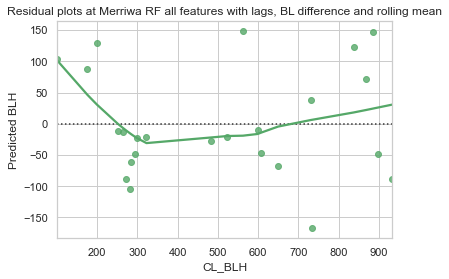

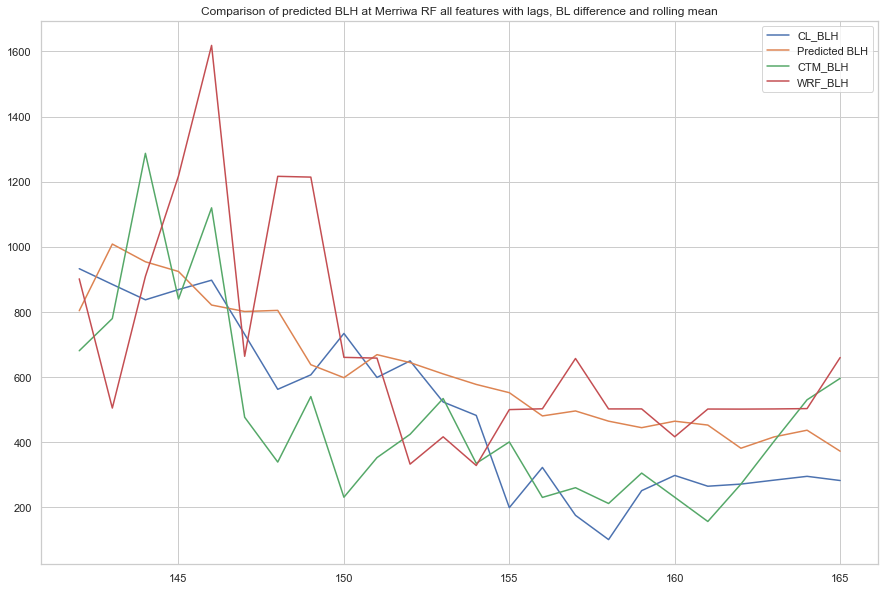

In [60]:
df_rf_merriwa_ld, rf_merriwa_ld = rf_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa RF all features with lags, BL difference and rolling mean')

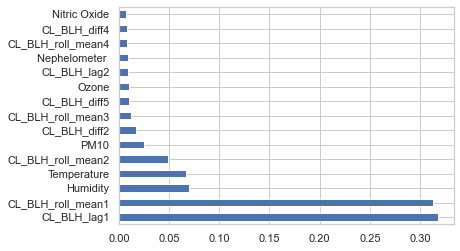

In [61]:
feature_importance_plot(rf_merriwa_ld, feature_list_all_ldm)

At Lidcombe RF all features with lags, BL difference and rolling mean
Index of agreement:0.73155
Root mean squared error:250.01886
Mean absoluate error:199.12438
Mean bias error:45.31706
DTW distance:1960.40
MASE:0.90533


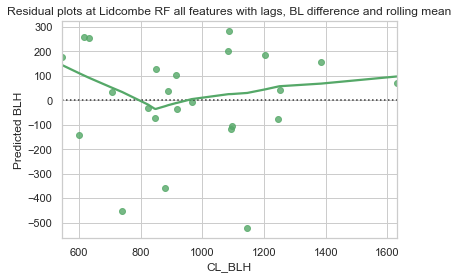

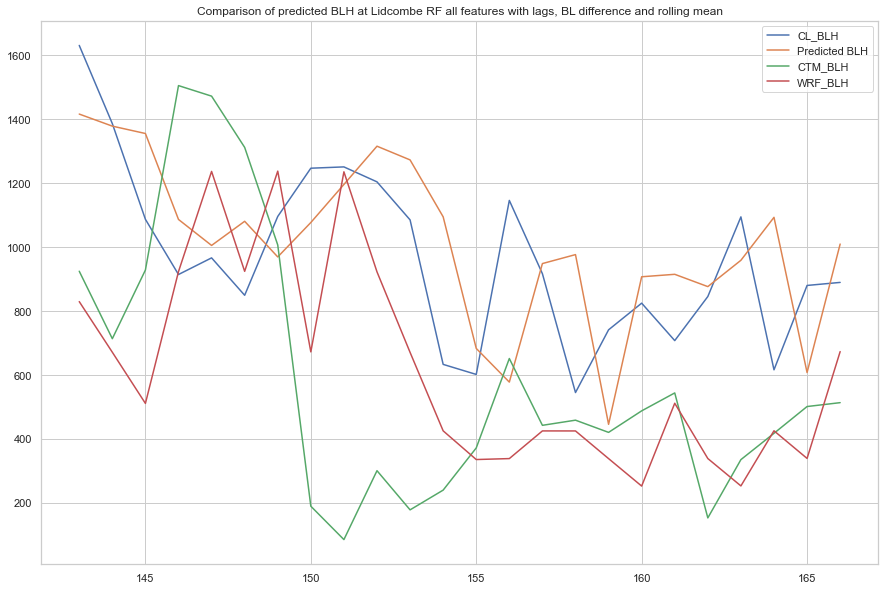

In [62]:
df_rf_lidcombe_ld, rf_lidcombe_ld = rf_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_rf_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe RF all features with lags, BL difference and rolling mean')

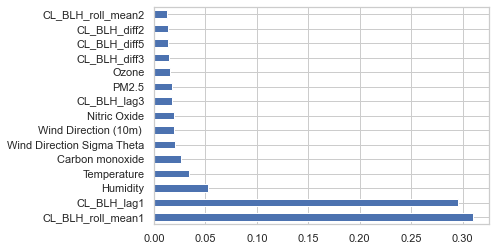

In [63]:
feature_importance_plot(rf_lidcombe_ld, feature_list_all_ldm)

## 3.3 SVR 

In [64]:
from sklearn import svm

In [65]:
def svm_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    vreg = svm.LinearSVR()
    vreg.fit(X_train, y_train)
    
    #Predict
    
    vreg_predict = vreg.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  vreg_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, vreg

In [66]:
#Finding the important features for SVR
def svm_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Merriwa SVR all features with lags, BL difference and rolling mean
Index of agreement:0.90201
Root mean squared error:177.25452
Mean absoluate error:155.49609
Mean bias error:110.36550
DTW distance:2026.08
MASE:0.82263


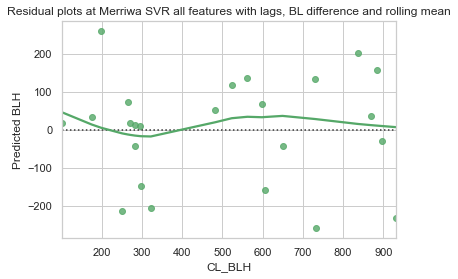

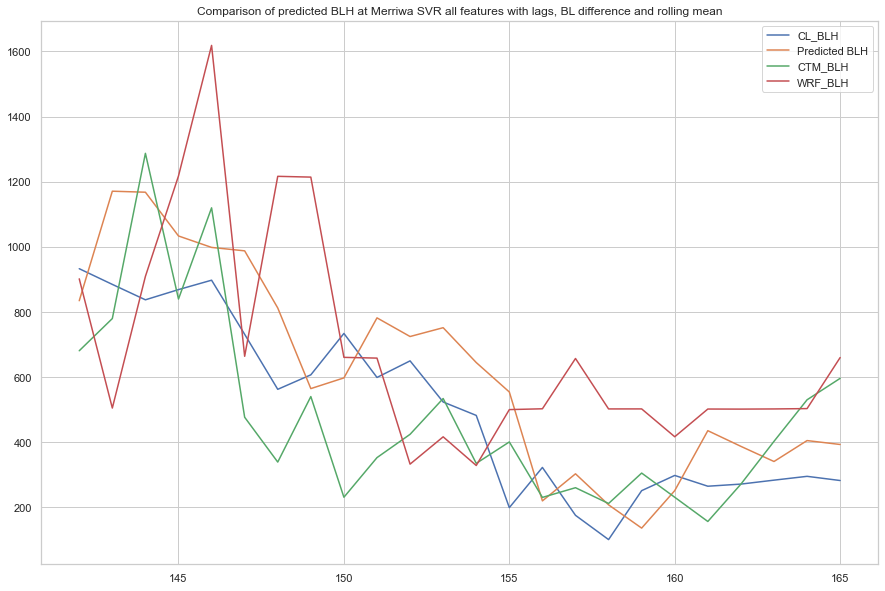

In [67]:
df_vreg_merriwa_ld, vreg_merriwa_ld = svm_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa SVR all features with lags, BL difference and rolling mean')

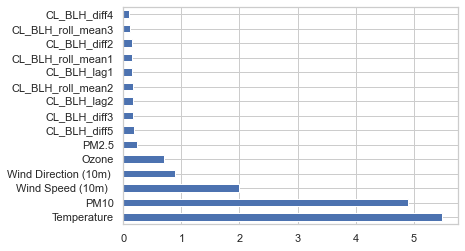

In [68]:
svm_feature_importance_plot(vreg_merriwa_ld, feature_list_all_ldm)

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\svm\_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


At Lidcombe SVR all features with lags, BL difference and rolling mean
Index of agreement:0.70096
Root mean squared error:308.18075
Mean absoluate error:243.51803
Mean bias error:217.42754
DTW distance:4077.68
MASE:1.10717


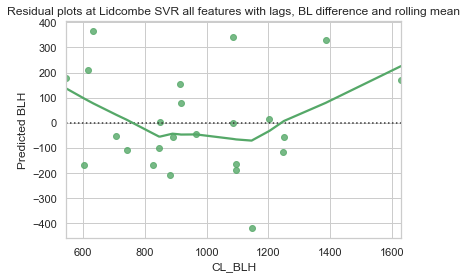

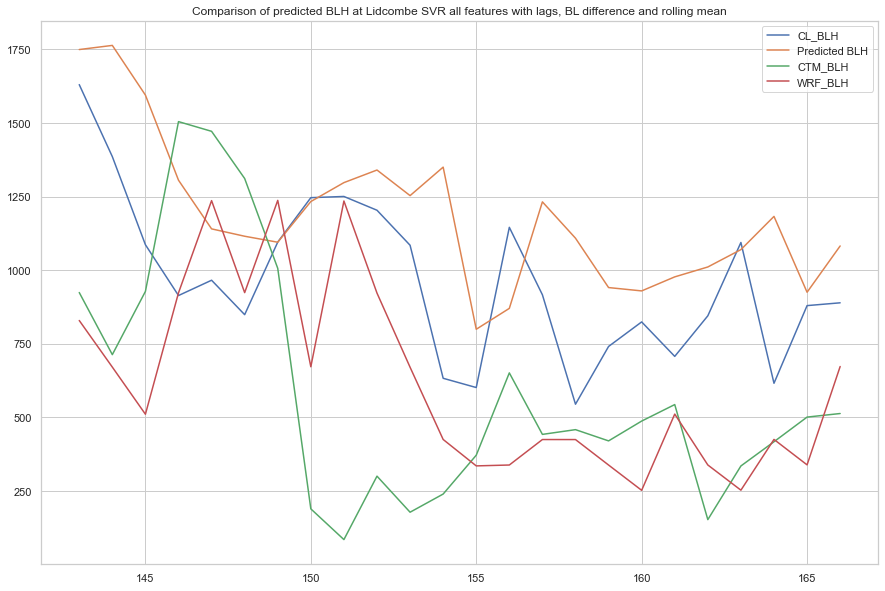

In [69]:
df_vreg_lidcombe_ld, vreg_lidcombe_ld = svm_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_vreg_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe SVR all features with lags, BL difference and rolling mean')

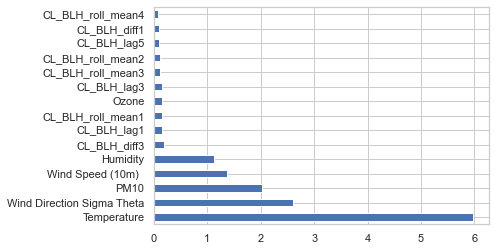

In [70]:
svm_feature_importance_plot(vreg_lidcombe_ld, feature_list_all_ldm)

## 3.3 Multiple linear regression 

In [71]:
from sklearn.linear_model import LinearRegression
#from matplotlib import pyplot

In [72]:
def mulin_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    mulin = LinearRegression()
    mulin.fit(X_train, y_train)
    
    #Predict
    
    mulin_predict = mulin.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  mulin_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, mulin

In [73]:
#Finding the important features for multiple linear regression
def mulin_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa MLR all features with lags, BL difference and rolling mean
Index of agreement:0.89563
Root mean squared error:142.83093
Mean absoluate error:116.67513
Mean bias error:55.78738
DTW distance:1589.89
MASE:0.61725


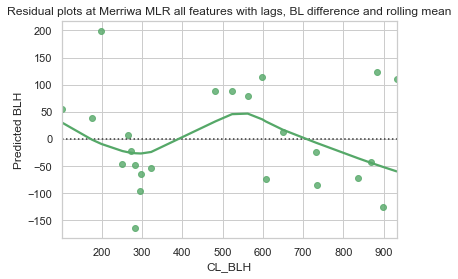

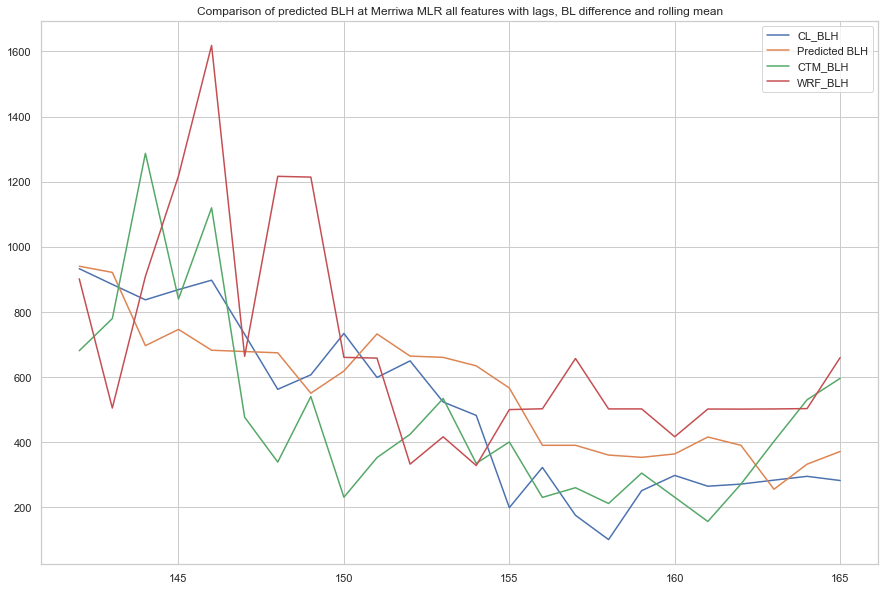

In [74]:
df_mulin_merriwa_ld, mulin_merriwa_ld = mulin_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_mulin_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa MLR all features with lags, BL difference and rolling mean')

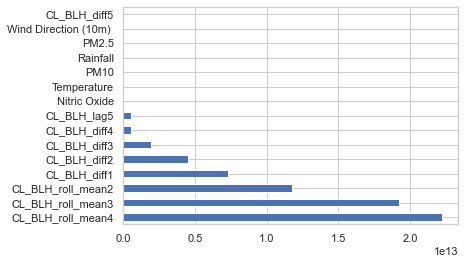

In [75]:
mulin_feature_importance_plot(mulin_merriwa_ld, feature_list_all_ldm)

At Lidcombe MLR all features with lags, BL difference and rolling mean
Index of agreement:0.63081
Root mean squared error:278.33622
Mean absoluate error:224.07049
Mean bias error:133.58979
DTW distance:3396.52
MASE:1.01875


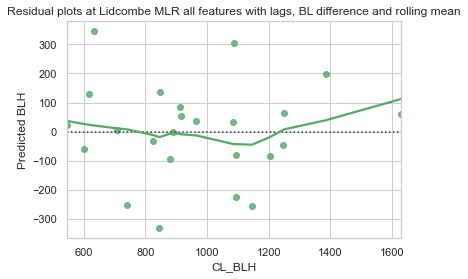

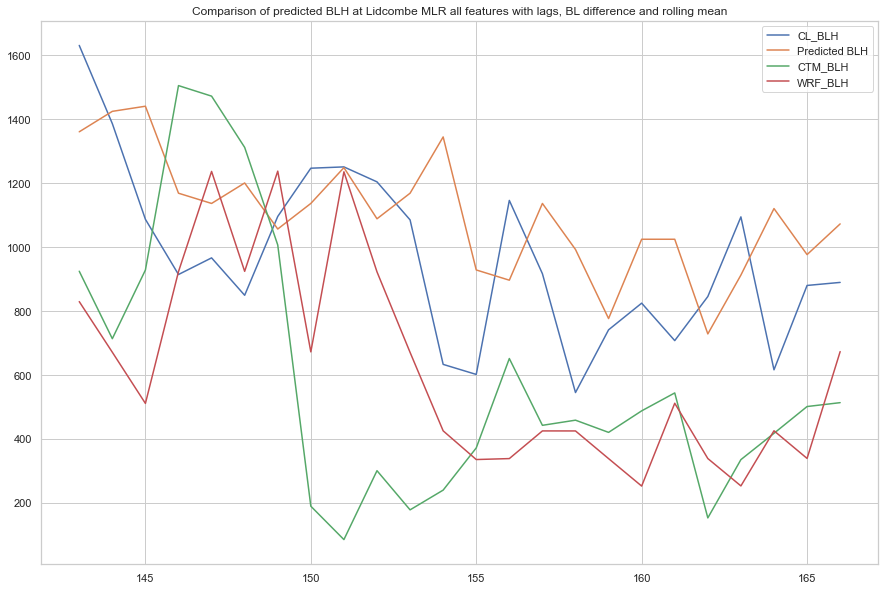

In [76]:
df_mulin_lidcombe_ld, mulin_lidcombe_ld = mulin_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_mulin_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe MLR all features with lags, BL difference and rolling mean')

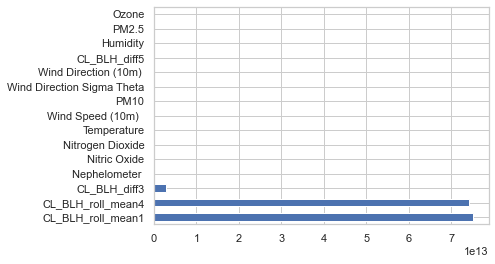

In [77]:
mulin_feature_importance_plot(mulin_lidcombe_ld, feature_list_all_ldm)

## 3.4 Decision tree 

In [78]:
from sklearn.tree import DecisionTreeRegressor

In [79]:
def tree_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    dtree = DecisionTreeRegressor()
    dtree.fit(X_train, y_train)
    
    #Predict
    
    dtree_predict = dtree.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  dtree_predict
    df_result['CTM_BLH'] = test['CTM_BLH']
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, dtree

In [80]:
#Finding the important features for Decision Tree regression
def dtree_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.72629
Root mean squared error:286.27092
Mean absoluate error:232.35414
Mean bias error:228.71365
DTW distance:2664.33
MASE:1.22923


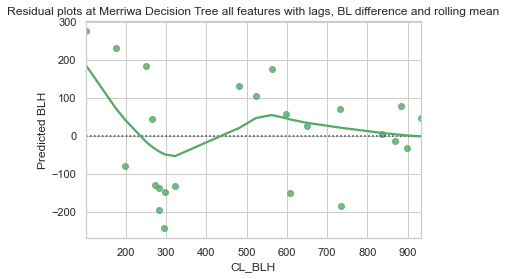

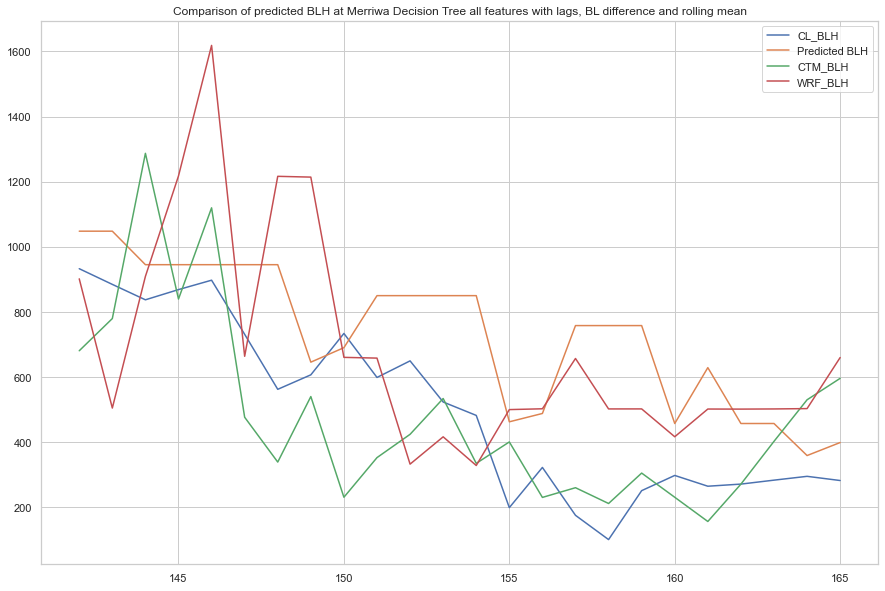

In [81]:
df_dtree_merriwa_ld, dtree_merriwa_ld = tree_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_dtree_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Decision Tree all features with lags, BL difference and rolling mean')

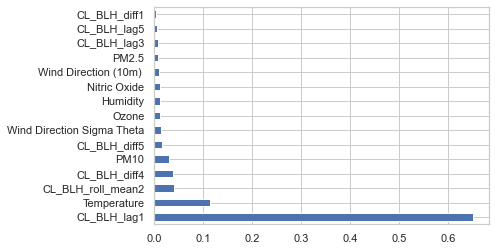

In [82]:
dtree_feature_importance_plot(dtree_merriwa_ld, feature_list_all_ldm)

At Lidcombe Decision Tree all features with lags, BL difference and rolling mean
Index of agreement:0.41253
Root mean squared error:441.47454
Mean absoluate error:376.52965
Mean bias error:87.29127
DTW distance:7403.04
MASE:1.71191


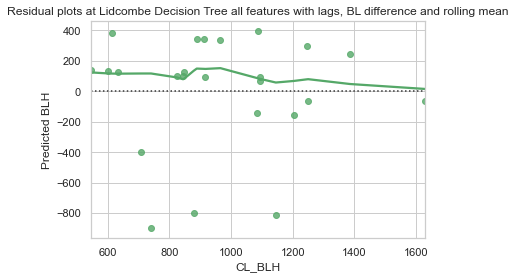

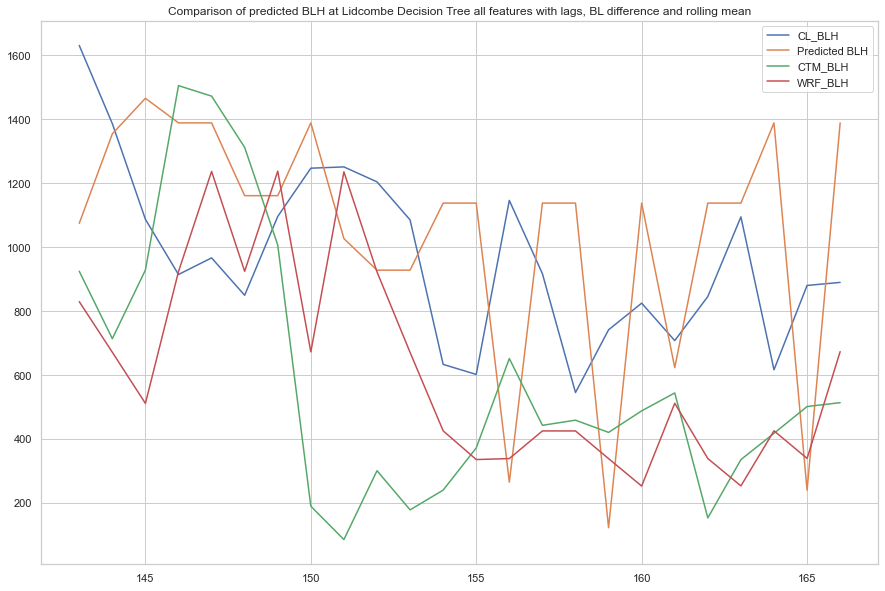

In [83]:
df_dtree_lidcombe_ld, dtree_lidcombe_ld = tree_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_dtree_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Decision Tree all features with lags, BL difference and rolling mean')

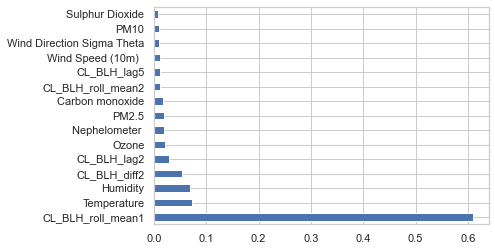

In [84]:
dtree_feature_importance_plot(dtree_lidcombe_ld, feature_list_all_ldm)

## 3.5 Lasso regression 

In [85]:
from sklearn.linear_model import Lasso

In [86]:
def lasso_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    lasso = Lasso()
    lasso.fit(X_train, y_train)
    
    #Predict
    
    lasso_predict = lasso.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  lasso_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, lasso

In [87]:
#Finding the important features for Lasso regression
def lasso_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166912.74237047043, tolerance: 3241.4653704070147
  positive)


At Merriwa Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.82657
Root mean squared error:198.42459
Mean absoluate error:171.73501
Mean bias error:157.82086
DTW distance:2534.20
MASE:0.90854


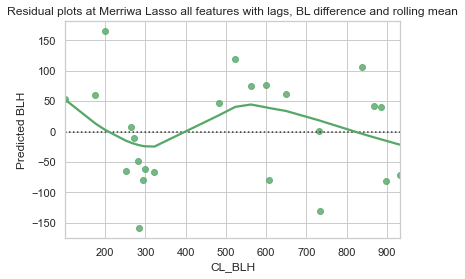

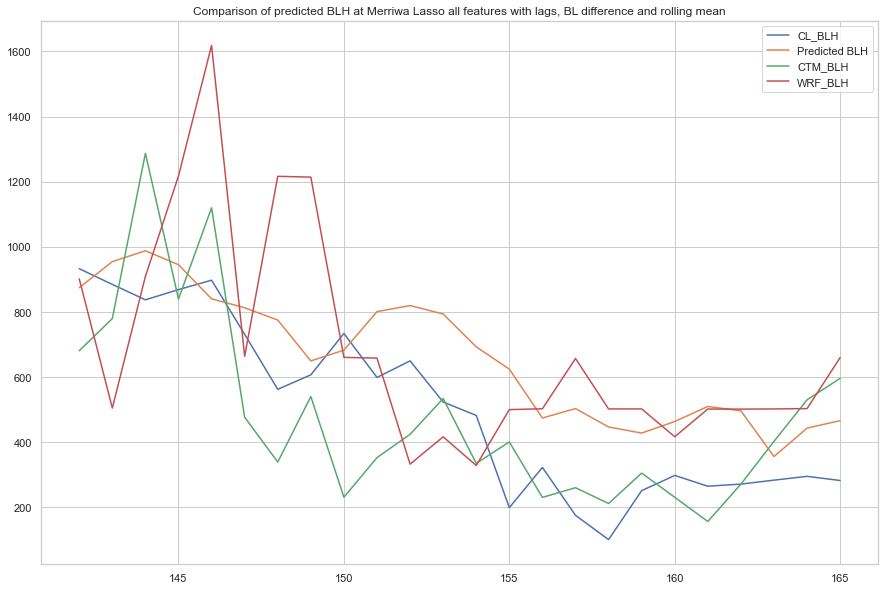

In [88]:
df_lasso_merriwa_ld, lasso_merriwa_ld = lasso_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_lasso_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Lasso all features with lags, BL difference and rolling mean')

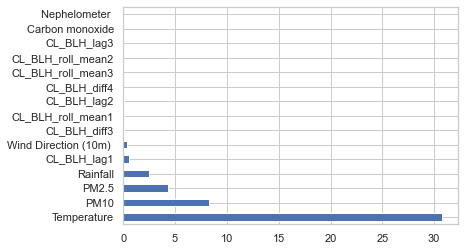

In [89]:
lasso_feature_importance_plot(lasso_merriwa_ld, feature_list_all_ldm)

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 564715.0723476317, tolerance: 2669.3468748598616
  positive)


At Lidcombe Lasso all features with lags, BL difference and rolling mean
Index of agreement:0.72395
Root mean squared error:240.73120
Mean absoluate error:191.80927
Mean bias error:-23.47695
DTW distance:2599.98
MASE:0.87207


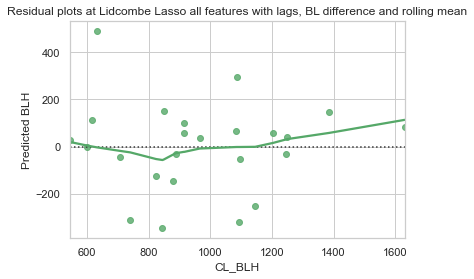

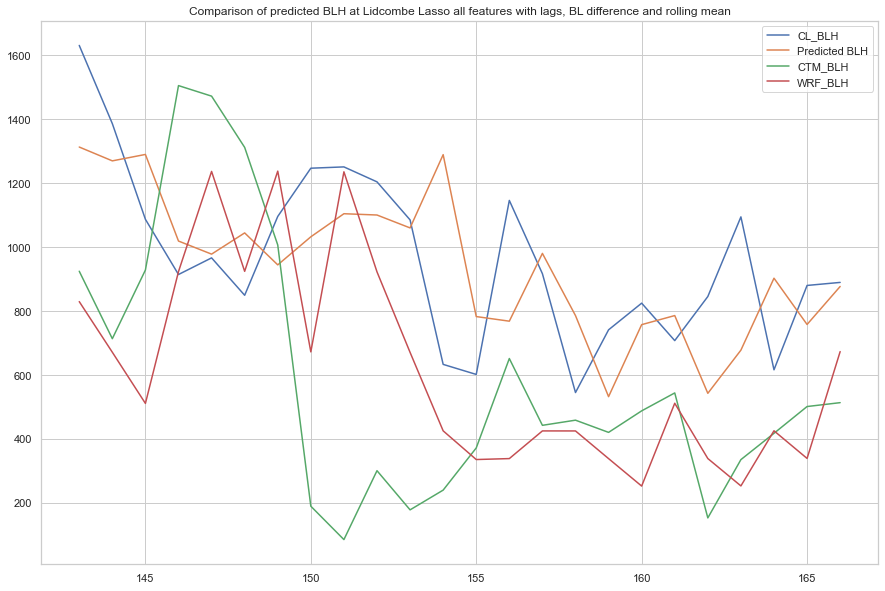

In [90]:
df_lasso_lidcombe_ld, lasso_lidcombe_ld = lasso_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_lasso_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Lasso all features with lags, BL difference and rolling mean')

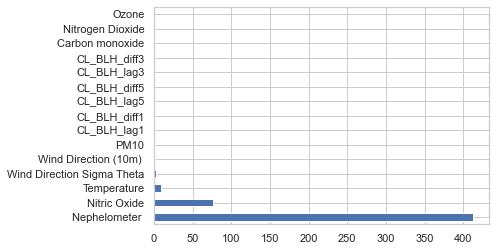

In [91]:
lasso_feature_importance_plot(lasso_lidcombe_ld, feature_list_all_ldm)

## 3.6 Ridge regression 

In [92]:
from sklearn.linear_model import Ridge

In [93]:
def ridge_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    ridge = Ridge()
    ridge.fit(X_train, y_train)
    
    #Predict
    
    ridge_predict = ridge.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  ridge_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, ridge

In [94]:
#Finding the important features for Ridge regression
def ridge_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

At Merriwa Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.82291
Root mean squared error:200.92969
Mean absoluate error:173.46569
Mean bias error:159.90192
DTW distance:2507.00
MASE:0.91769


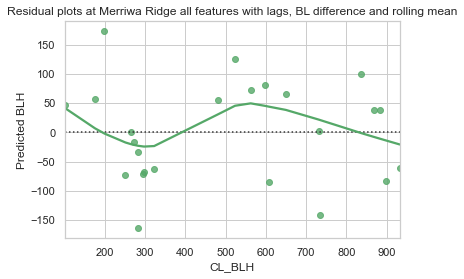

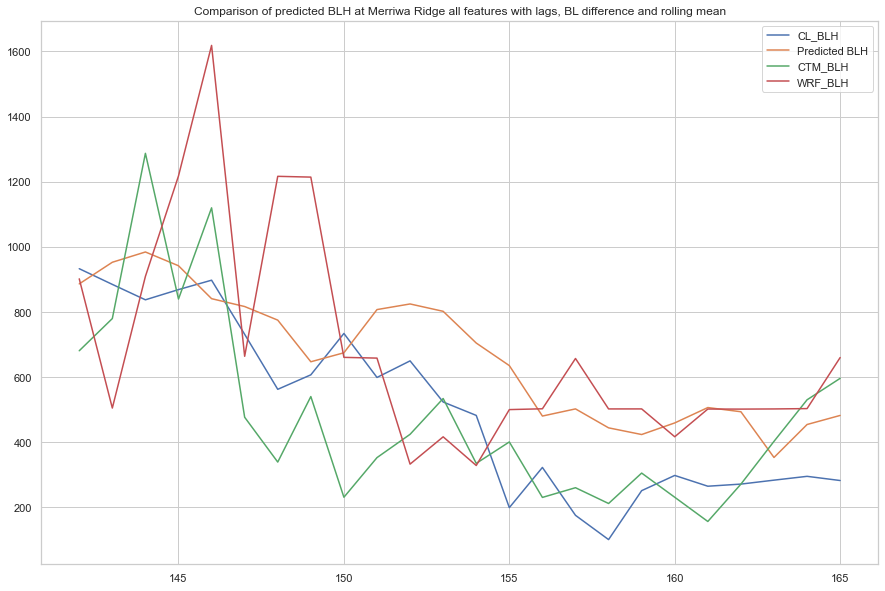

In [95]:
df_ridge_merriwa_ld, ridge_merriwa_ld = ridge_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_ridge_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa Ridge all features with lags, BL difference and rolling mean')

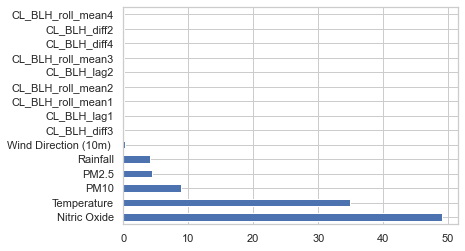

In [96]:
ridge_feature_importance_plot(ridge_merriwa_ld, feature_list_all_ldm)

At Lidcombe Ridge all features with lags, BL difference and rolling mean
Index of agreement:0.74312
Root mean squared error:235.45091
Mean absoluate error:188.01339
Mean bias error:-27.25630
DTW distance:2402.75
MASE:0.85481


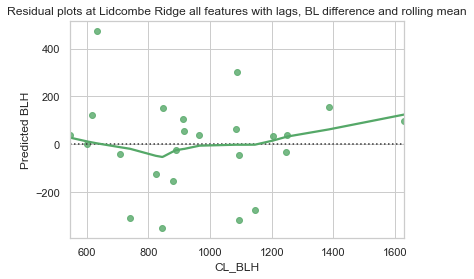

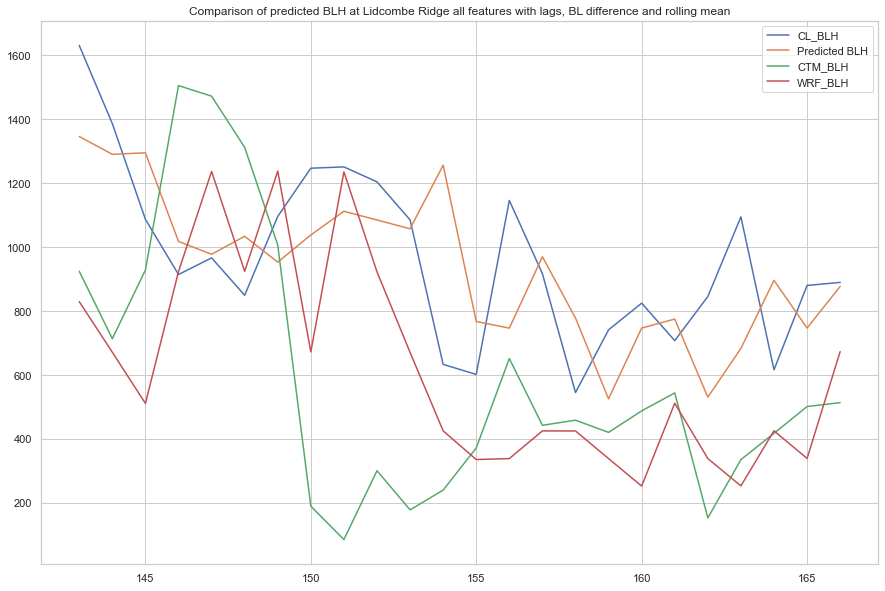

In [97]:
df_ridge_lidcombe_ld, ridge_lidcombe_ld = ridge_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_ridge_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe Ridge all features with lags, BL difference and rolling mean')

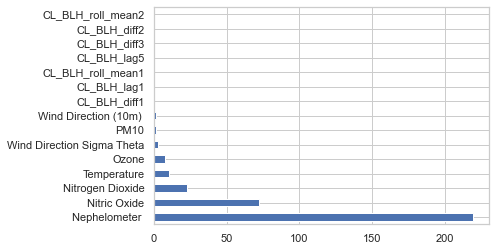

In [98]:
ridge_feature_importance_plot(ridge_lidcombe_ld, feature_list_all_ldm)

## 3.7 Elastic Net

In [99]:
from sklearn.linear_model import ElasticNet

In [100]:
def enet_modeller(df, feature_list, target):
    #Train and test split
    
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    #Model fitting
    
    enet = ElasticNet()
    enet.fit(X_train, y_train)
    
    #Predict
    
    enet_predict = enet.predict(X_test)
    
    
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  enet_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    df_result['WRF_BLH'] = test['WRF_BLH']
    return df_result, enet

In [101]:
#Finding the important features for ElasticNet regression
def enet_feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.coef_, index=feature_list)
    feat_importances.nlargest(15).plot(kind='barh')

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 883953.2339301459, tolerance: 3241.4653704070147
  positive)


At Merriwa ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.86317
Root mean squared error:178.15907
Mean absoluate error:153.83940
Mean bias error:139.44540
DTW distance:2603.41
MASE:0.81386


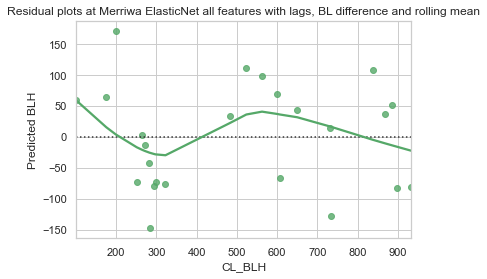

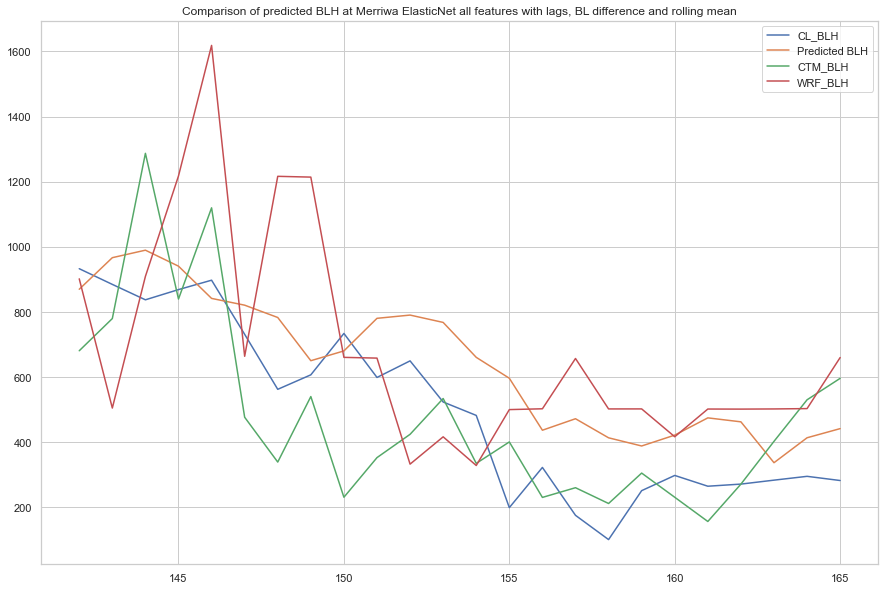

In [102]:
df_enet_merriwa_ld, enet_merriwa_ld = enet_modeller(df_merriwa_wlags, feature_list_all_ldm, 'CL_BLH')
results_print(df_enet_merriwa_ld, df_merriwa_filled.head(142)['CL_BLH'], 'Merriwa ElasticNet all features with lags, BL difference and rolling mean')

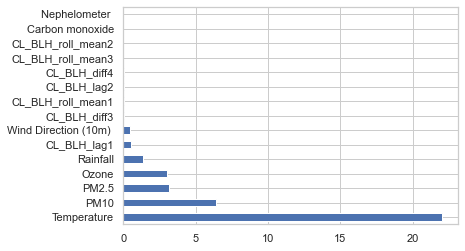

In [103]:
enet_feature_importance_plot(enet_merriwa_ld, feature_list_all_ldm)

C:\Users\vichu\anaconda3\envs\rstudio\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 651630.8384954678, tolerance: 2669.3468748598616
  positive)


At Lidcombe ElasticNet all features with lags, BL difference and rolling mean
Index of agreement:0.77817
Root mean squared error:224.76116
Mean absoluate error:182.56031
Mean bias error:-49.34501
DTW distance:2655.09
MASE:0.83002


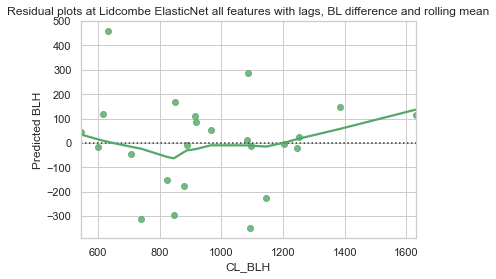

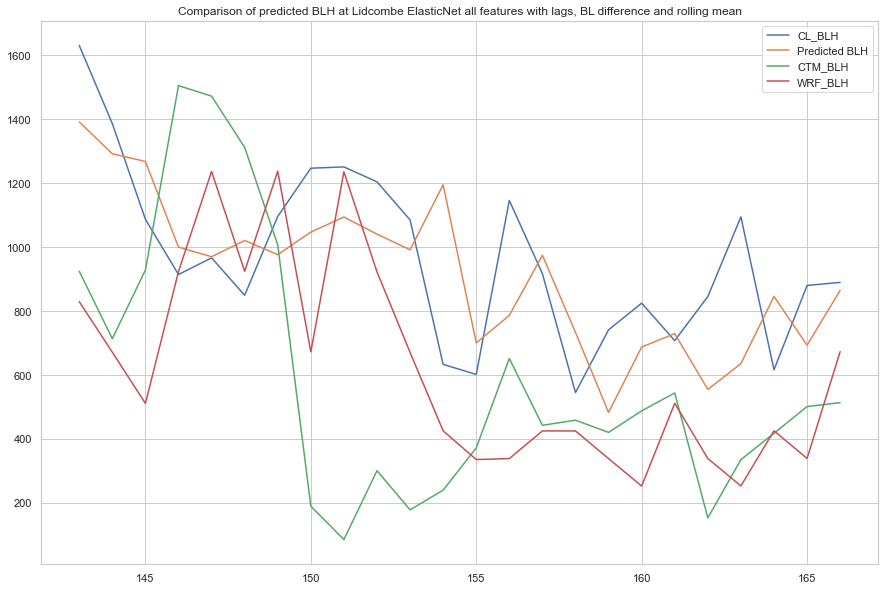

In [104]:
df_enet_lidcombe_ld, enet_lidcombe_ld = enet_modeller(df_lidcombe_wlags, feature_list_all_ldm, 'CL_BLH') 
results_print(df_enet_lidcombe_ld, df_lidcombe_filled.head(142)['CL_BLH'], 'Lidcombe ElasticNet all features with lags, BL difference and rolling mean')

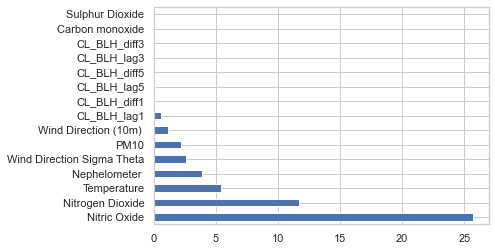

In [90]:
enet_feature_importance_plot(enet_lidcombe_ld, feature_list_all_ldm)